### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from collections import deque
import random

import matplotlib.dates as mdates
import seaborn as sns

/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
### Cleaning Alpha Vantage Data
df_sentiment = pd.read_csv("./datasets/dow30_monthly_news_sentiment.csv")
df_sentiment.tail()
df_sentiment.drop(columns=["title", "summary", "source", "url"], inplace=True)
df_sentiment["date"] = pd.to_datetime(df_sentiment["published_time"]).dt.date
df_sentiment.drop(columns=["published_time"], inplace=True) 
df_sentiment.tail()
df_sentiment.groupby(["date", "ticker"]).agg({"ticker_sentiment_score": "mean"}).head()
df_sentiment["weighted_score"] = (
    df_sentiment["ticker_sentiment_score"] * df_sentiment["ticker_relevance_score"]
)

agg_df = (
    df_sentiment
    .groupby(["date", "ticker"])
    .agg(
        raw_avg_sentiment=("ticker_sentiment_score", "mean"),
        total_relevance=("ticker_relevance_score", "sum"),
        weighted_sum=("weighted_score", "sum"),
        article_count=("ticker_sentiment_score", "count")
    )
    .reset_index()
)

# Compute final weighted average
agg_df["weighted_avg_sentiment"] = (
    agg_df["weighted_sum"] / agg_df["total_relevance"]
)

agg_df.sort_values(by=["date", "ticker"], inplace=True)
agg_df.tail()
apple = agg_df[agg_df["ticker"] == "AAPL"]
full_date_range = pd.date_range(start="2022-03-01", end="2025-04-23", freq='D').date
# missing_dates = full_date_range.difference(apple['date'])

# print("Missing dates:")
# print(missing_dates)
all_combinations = pd.MultiIndex.from_product(
    [agg_df['ticker'].unique(), full_date_range],
    names=['ticker', 'date']
).to_frame(index=False)
merged_df = pd.merge(
    all_combinations,
    agg_df,
    how='left',
    on=['ticker', 'date']
)
merged_df[merged_df.isnull().any(axis=1)].head(30)
merged_df["date"] = merged_df["date"] + pd.Timedelta(days=1)
merged_df = merged_df.fillna(0).sort_values(by=["date", "ticker"])
merged_df.to_csv("dow30_news_sentiment.csv", index=False)
merged_df.tail()

,ticker,date,raw_avg_sentiment,total_relevance,weighted_sum,article_count,weighted_avg_sentiment
12649,TSLA,2025-04-24,0.102081,6.638020,0.702583,15.0,0.105842
28749,UNH,2025-04-24,0.000000,0.000000,0.000000,0.0,0.000000
13799,V,2025-04-24,0.098999,0.059488,0.005889,1.0,0.098999
14949,WMT,2025-04-24,0.141068,0.503241,0.095014,2.0,0.188804
16099,XOM,2025-04-24,0.069925,0.120130,0.008400,1.0,0.069925


In [3]:
### Download Data from Yahoo Finance
df_sentiment = pd.read_csv("dow30_news_sentiment.csv")
TICKERS = df_sentiment["ticker"].unique().tolist()
START_DATE, END_DATE ="2022-03-02", "2025-04-23"
from finrl import config_tickers
df = YahooDownloader(start_date = START_DATE,
                           end_date = END_DATE,
                           ticker_list = TICKERS).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (21276, 8)


In [4]:
### Add technical Indicators
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=False,
                      user_defined_feature = False).preprocess_data(df.copy())
# df=df.sort_values(['date','tic'],ignore_index=True)
# df.index = df.date.factorize()[0]

# cov_list = []
# # look back is one year
# lookback=252
# for i in range(lookback,len(df.index.unique())):
#   data_lookback = df.loc[i-lookback:i,:]
#   price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
#   return_lookback = price_lookback.pct_change().dropna()
#   covs = return_lookback.cov().values
#   cov_list.append(covs)

# df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
# df = df.merge(df_cov, on='date')
# df = df.sort_values(['date','tic']).reset_index(drop=True)
# df.head()
df.tic.unique()

Successfully added technical indicators


array(['AAPL', 'ABBV', 'ACN', 'ADBE', 'AMZN', 'AVGO', 'BAC', 'COST',
       'CRM', 'CVX', 'GOOG', 'HD', 'KO', 'LLY', 'MA', 'META', 'MSFT',
       'NVDA', 'ORCL', 'PEP', 'PG', 'TMO', 'TSLA', 'UNH', 'V', 'WMT',
       'XOM'], dtype=object)

In [5]:
### Merge sentiment and technical data
df_sentiment.head()
df_sentiment.rename(columns = {'Date':'date', 'ticker':'tic'}, inplace = True)
merged_df = df.merge(df_sentiment, on=['date', 'tic'], how='inner')

merged_df.drop(columns=['raw_avg_sentiment', 'total_relevance', "weighted_sum","article_count" ], inplace=True)
merged_df.head()
merged_df.to_csv("./merged_df.csv", index=False)

### Train-Test Split

In [6]:
df=merged_df.copy()


In [7]:
START_DATE, END_DATE ="2022-03-02", "2025-04-23"
TRAIN_START_DATE = START_DATE
TRAIN_END_DATE = "2024-03-01"
TEST_START_DATE = "2024-03-01"
TEST_END_DATE = END_DATE

In [8]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TEST_START_DATE,TEST_END_DATE)

In [9]:
train.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,weighted_avg_sentiment
0,2022-03-02,163.904175,167.360001,162.949997,164.389999,79724800,AAPL,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,163.904175,163.904175,-0.247750
0,2022-03-02,132.393127,151.250000,147.220001,147.699997,8247200,ABBV,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,132.393127,132.393127,0.134635
0,2022-03-02,302.242523,320.260010,312.549988,315.420013,2220800,ACN,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,302.242523,302.242523,0.000000
0,2022-03-02,471.179993,477.489990,466.040009,471.940002,2948500,ADBE,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,471.179993,471.179993,0.000000
0,2022-03-02,152.052505,152.999496,148.750000,150.848999,47334000,AMZN,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,152.052505,152.052505,0.056996


### Environment Setup

In [10]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (len(config.INDICATORS)+1)*stock_dimension #stock, shares, technical indicators, 

In [11]:
print(stock_dimension)
print(state_space)

27
298


In [12]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS + ["weighted_avg_sentiment"],  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4,  # Scaling factor for rewards to normalize them and improve learning stability.
    "print_verbosity":5
}

### Custom Trading Environment

In [13]:
class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
            # Call the parent constructor
            super().__init__(df=df, **kwargs)
            self.action_space = spaces.Box(
            low=-self.hmax, 
            high=self.hmax, 
            shape=(self.stock_dim,), 
            dtype=np.float32
        )
    def save_state_memory(self):
        """Save state memory dynamically without hard-coded column names."""
        if len(self.df.tic.unique()) > 1:
            # Get the date memory (excluding the last one)
            date_list = self.date_memory[:-1]

            # Ensure state_list is not empty
            state_list = self.state_memory
            # print(len(state_list[0]))
            if not state_list:
                print("Warning: state_memory is empty!")
                return pd.DataFrame()  # Return an empty DataFrame if no data exists

            # Ensure each state has the same structure
            try:
                num_features = len(state_list[0])  # Get number of features from the first state
                state_columns = [f"feature_{i}" for i in range(num_features)]  # Generate feature names
            except IndexError:
                print("Error: state_memory contains empty entries.")
                return pd.DataFrame()  # Return an empty DataFrame if there's an issue

            df_date = pd.DataFrame(date_list, columns=["date"])
            df_states = pd.DataFrame(state_list, columns=state_columns)
            df_states.index = df_date["date"]  # Set index to match dates
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})

        return df_states
    # def step(self, action):
    #     # Clip actions to feasible shares based on current holdings
    #     # print(action)
    #     for i in range(self.stock_dim):
    #         current_shares = self.state[i * 2 + 1]
    #         action[i] = np.clip(action[i], -current_shares, self.hmax)
        
    #     return super().step(action)
    def step(self, action, state = None):
        # Clip actions to feasible shares based on current holdings
        if state is not None:
            self.state = state
        for i in range(self.stock_dim):
            current_shares = self.state[i * 2 + 1]
            action[i] = np.clip(action[i], -current_shares, self.hmax)
        
        return super().step(action)
    

### Multi-Layer Perceptron

In [14]:
class MetaPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hmax=100):
        """
        :param hmax: Maximum shares allowed (used for action scaling)
        """
        super().__init__()
        self.hmax = hmax
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Outputs in [-1, 1] for easy scaling
        )
    
    def forward(self, x):
        # Outputs in [-1, 1], scaled to [-hmax, hmax]
        return self.net(x) * self.hmax

### Define Meta Environment

In [15]:
meta_env_train_gym = CustomStockTradingEnv(df=train, **env_kwargs)
meta_env_train, obs = meta_env_train_gym.get_sb_env()
# print(obs)
num_stocks  = meta_env_train_gym.action_space.shape[0]
state_features_dim = meta_env_train_gym.state_space
num_base_models = 3
input_dim = num_base_models * num_stocks + state_features_dim
output_dim = num_stocks
hidden_dim = 64 

### Get Base Models

In [16]:
agent = DRLAgent(env = meta_env_train)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg_sentiment")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo_sentiment", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c_sentiment", device='cpu')
model_td3 = agent.get_model("td3")
trained_td3 = model_td3.load(config.TRAINED_MODEL_DIR + "/agent_td3_sentiment")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu

### Define Meta Model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
meta_policy_model = MetaPolicy(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=1e-3)

In [19]:
# Initialize replay buffer with a maximum capacity (e.g., 10,000 transitions)
replay_buffer = deque(maxlen=10000)
batch_size = 64  # Number of transitions to sample per training step

In [20]:
def DRL_prediction(model, environment, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        # print(test_obs)
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states
        state_memory = None
        rewards_memory = []

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            next_obs, rewards, dones, info = test_env.step(action)
            rewards_memory.append(rewards)
            # state_memory.append(test_obs)
            test_obs = next_obs
            if (
                i == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
                state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break
        # state_columns = [f"feature_{i}" for i in range(len(state_memory[0][0]))]
        # state_memory = pd.DataFrame([i[0] for i in state_memory], columns=state_columns)
        return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)

In [21]:
def evaluate_model(model, model_name):
    """Run backtesting for an individual DRL model and return account history."""
    env = CustomStockTradingEnv(df=trade, **env_kwargs)
    
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model=model,
        environment=env
    )
    backtest_stats(df_account_value)
    return df_account_value
# Evaluate DDPG
ddpg_results = evaluate_model(trained_ddpg, "DDPG")

# Evaluate PPO
ppo_results = evaluate_model(trained_ppo, "PPO")

# Evaluate A2C
a2c_results = evaluate_model(trained_a2c, "A2C")

td3_results = evaluate_model(trained_td3, "TD3")

hit end!
Annual return          0.024146
Cumulative returns     0.027448
Annual volatility      0.168114
Sharpe ratio           0.225961
Calmar ratio           0.145299
Stability              0.501418
Max drawdown          -0.166181
Omega ratio            1.042420
Sortino ratio          0.325844
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.932722
Daily value at risk   -0.021030
dtype: float64
hit end!
Annual return          0.034703
Cumulative returns     0.039476
Annual volatility      0.249916
Sharpe ratio           0.261289
Calmar ratio           0.182853
Stability              0.210209
Max drawdown          -0.189785
Omega ratio            1.048107
Sortino ratio          0.374013
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.846240
Daily value at risk   -0.031227
dtype: float64
hit end!
Annual return          0.093441
Cumulative returns     0.106700
Annual volatility      0.201115
Sharpe ratio   

In [22]:
df_dji = YahooDownloader(
    start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^DJI"]
).fetch_data()
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)
baseline_df = get_baseline(
    ticker="^DJI",
    start=TEST_START_DATE,
    end=TEST_END_DATE,
)
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)
Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


In [23]:
def plot_trading_results(ensemble_results, ddpg_results, ppo_results, a2c_results, dji, baseline_df):
    # Set a Seaborn theme for a cleaner look
    sns.set_theme(style='whitegrid', context='talk')

    # Optionally, define a Seaborn color palette
    palette = sns.color_palette("colorblind", 5)

    # Convert 'date' columns to datetime if they are not already
    ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
    ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
    ppo_results['date'] = pd.to_datetime(ppo_results['date'])
    a2c_results['date'] = pd.to_datetime(a2c_results['date'])
    dji['date'] = pd.to_datetime(baseline_df['date'])

    # Create the figure
    plt.figure(figsize=(14, 7))

    # Plot each series using Seaborn's palette for consistency
    plt.plot(ensemble_results['date'], ensemble_results['account_value'], 
            label='Ensemble (Meta-Policy NN)', linewidth=2, color=palette[0])
    plt.plot(ddpg_results['date'], ddpg_results['account_value'], 
            label='TD3', linestyle='--', alpha=0.7, color=palette[1])
    plt.plot(ppo_results['date'], ppo_results['account_value'], 
            label='PPO', linestyle='-.', alpha=0.7, color=palette[2])
    plt.plot(a2c_results['date'], a2c_results['account_value'], 
            label='A2C', linestyle=':', alpha=0.7, color=palette[3])
    plt.plot(dji['date'], dji['close'], 
            label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[4])

    # Format the x-axis for dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

    # Add titles and labels
    plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [21]:
ddpg_account_value, ddpg_actions, ddpg_states, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)

ppo_account_value, ppo_actions, ppo_states, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)

a2c_account_value, a2c_actions, a2c_states, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)

hit end!
hit end!
hit end!


In [22]:
decision_points = pd.concat([ddpg_states, ppo_states, a2c_states], axis=0)
decision_points.shape

(1503, 298)

#### Training Dataset

In [23]:
env = CustomStockTradingEnv(df=train, **env_kwargs)

In [24]:
dataset = []
for i in range(len(decision_points)):
    row = decision_points.iloc[i]
    state = row.values
    # print(state)
    action_best = None
    reward_best = -np.inf
    actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        actions.append(action)
        next_state, reward, done, info, _ = env.step(action, state)
        if reward > reward_best:
            reward_best = reward
            action_best = action
    input_vector = np.concatenate([np.concatenate(actions), state])
    dataset.append((input_vector, action_best))

# print(len(dataset))        
    

day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1055449.66
total_reward: 55449.66
total_cost: 47224.33
total_trades: 8628
Sharpe: 0.762
day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1055449.66
total_reward: 55449.66
total_cost: 47224.33
total_trades: 8628
Sharpe: 0.762
day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1055449.66
total_reward: 55449.66
total_cost: 47224.33
total_trades: 8628
Sharpe: 0.762
day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1053322.20
total_reward: 53322.20
total_cost: 47224.33
total_trades: 8628
Sharpe: 0.762
day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1053322.20
total_reward: 53322.20
total_cost: 47224.33
total_trades: 8628
Sharpe: 0.762
day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1053322.20
total_reward: 53322.20
total_cost: 47224.33
total_trades: 8628
Sharpe: 0.762
day: 501, episode: 0
begin_total_asset: 1000000.00
end_total_ass

In [25]:
D = TensorDataset(torch.FloatTensor(np.array([i[0] for i in dataset])), torch.FloatTensor(np.array([i[1] for i in dataset])))
loader = DataLoader(D, batch_size=64, shuffle=True, pin_memory=True)

In [26]:
meta_policy_model = MetaPolicy(input_dim, 128, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=0.001)

In [27]:
episodes = 2000

In [28]:
for episode in range(episodes):
    episode_loss = 0
    for input, label in loader:
        optimizer.zero_grad()
        
        input_tensor = torch.FloatTensor(input).to(device)
        label_tensor = torch.FloatTensor(label).to(device)
        
        predicted_action = meta_policy_model(input_tensor)

        loss = criterion(predicted_action, label_tensor)
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    # break
    print(f"Episode {episode} | Loss: {episode_loss}")

Episode 0 | Loss: 233502.9150390625
Episode 1 | Loss: 237602.2783203125
Episode 2 | Loss: 238124.5654296875
Episode 3 | Loss: 237960.3193359375
Episode 4 | Loss: 239363.029296875
Episode 5 | Loss: 239551.2744140625
Episode 6 | Loss: 239557.4228515625
Episode 7 | Loss: 239558.94140625
Episode 8 | Loss: 239556.8623046875
Episode 9 | Loss: 239560.7080078125
Episode 10 | Loss: 239558.650390625
Episode 11 | Loss: 239558.4453125
Episode 12 | Loss: 239559.3369140625
Episode 13 | Loss: 239553.17578125
Episode 14 | Loss: 239559.693359375
Episode 15 | Loss: 239570.33203125
Episode 16 | Loss: 239571.19140625
Episode 17 | Loss: 239570.60546875
Episode 18 | Loss: 239570.693359375
Episode 19 | Loss: 239571.75
Episode 20 | Loss: 239570.95703125
Episode 21 | Loss: 239570.7841796875
Episode 22 | Loss: 239570.6201171875
Episode 23 | Loss: 239572.2001953125
Episode 24 | Loss: 239572.54296875
Episode 25 | Loss: 239572.677734375
Episode 26 | Loss: 239571.5712890625
Episode 27 | Loss: 239570.8876953125
Epis

##### Backtesting performance

In [29]:
meta_env_trade_gym = CustomStockTradingEnv(df=trade, **env_kwargs)
meta_env_trade, obs = meta_env_trade_gym.get_sb_env()
agent = DRLAgent(env = meta_env_trade)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c", device='cpu')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [30]:
env = CustomStockTradingEnv(df=trade, **env_kwargs)
state = env.reset()

# ===== Step 2: Trading Loop with Meta-Policy Model =====
done = False
ensemble_account_history = []

while not done:
    # Preprocess state
    state = np.array(state[0]).reshape(-1)
    
    # Collect actions from base DRL models
    base_actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        base_actions.append(action)
    base_actions = np.concatenate(base_actions).reshape(-1)
    
    # Create input vector for meta-policy model
    input_vector = np.concatenate([base_actions, state])
    input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
    
    # Predict final action using meta-policy model
    with torch.no_grad():
        predicted_action = meta_policy_model(input_tensor)
    action = predicted_action.cpu().numpy()[0]

    # Execute trade
    next_state, reward, done, info, _ = env.step(action)
    state = [next_state]

# Save and Display Ensemble Results
ensemble_account_history = env.save_asset_memory()
ensemble_results = pd.DataFrame(ensemble_account_history, columns=["date", "account_value"])


In [31]:
backtest_stats(ensemble_results, value_col_name="account_value")

Annual return          0.056015
Cumulative returns     0.063809
Annual volatility      0.346926
Sharpe ratio           0.328692
Calmar ratio           0.227275
Stability              0.013688
Max drawdown          -0.246462
Omega ratio            1.062299
Sortino ratio          0.489169
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.855283
Daily value at risk   -0.043256
dtype: float64


Annual return          0.056015
Cumulative returns     0.063809
Annual volatility      0.346926
Sharpe ratio           0.328692
Calmar ratio           0.227275
Stability              0.013688
Max drawdown          -0.246462
Omega ratio            1.062299
Sortino ratio          0.489169
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.855283
Daily value at risk   -0.043256
dtype: float64

In [ ]:
df_dji = YahooDownloader(
    start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^DJI"]
).fetch_data()
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)
baseline_df = get_baseline(
    ticker="^DJI",
    start=TEST_START_DATE,
    end=TEST_END_DATE,
)
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


/tmp/ipykernel_45649/2896284701.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Training (Knowledge Distillation)

In [24]:

# --- 1. Collect States from Individual Model Rollouts ---
# (Using your existing DRL_prediction function)

print("Running DDPG prediction to collect states...")
ddpg_account_value, ddpg_actions, ddpg_states_df, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(ddpg_states_df)} states from DDPG.")

print("Running PPO prediction to collect states...")
ppo_account_value, ppo_actions, ppo_states_df, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(ppo_states_df)} states from PPO.")

print("Running A2C prediction to collect states...")
a2c_account_value, a2c_actions, a2c_states_df, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(a2c_states_df)} states from A2C.")

print("Running TD3 prediction to collect states...")
td3_account_value, td3_actions, td3_states_df, td3_rewards = DRL_prediction(
    trained_td3, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(td3_states_df)} states from TD3.")

Running DDPG prediction to collect states...
hit end!
Collected 501 states from DDPG.
Running PPO prediction to collect states...
hit end!
Collected 501 states from PPO.
Running A2C prediction to collect states...
hit end!
Collected 501 states from A2C.
Running TD3 prediction to collect states...
hit end!
Collected 501 states from TD3.


In [25]:
# --- 2. Create the State Dataset (states_np) ---

# Concatenate states collected from all models
all_states_df = pd.concat([ddpg_states_df, ppo_states_df, a2c_states_df], axis=0, ignore_index=True)

# Drop duplicate states to create a unique set of decision points
# Note: This assumes your states are represented correctly row-wise in the DataFrame.
# If states contain lists/arrays within cells, dropping duplicates might need adjustment.
unique_states_df = all_states_df.drop_duplicates()

print(f"Total states collected: {len(all_states_df)}")
print(f"Unique states found: {len(unique_states_df)}")

# Convert the unique states DataFrame into a NumPy array
# This will be the input (X) for your student model
states_np = unique_states_df.values

Total states collected: 1503
Unique states found: 1503


In [26]:
# --- 3. Generate Target Actions (target_actions_np) ---

target_actions_list = []
num_unique_states = len(states_np)

print(f"\nGenerating averaged target actions for {num_unique_states} unique states...")

# Loop through each unique state
for i, state in enumerate(states_np):
    # Get deterministic predictions from each teacher model for the current state
    # IMPORTANT: Use deterministic=True for knowledge distillation targets
    action_ddpg, _ = trained_ddpg.predict(state, deterministic=True)
    action_ppo, _ = trained_ppo.predict(state, deterministic=True)
    action_a2c, _ = trained_a2c.predict(state, deterministic=True)

    # Average the predicted actions
    # Ensure they are numpy arrays for correct addition
    target_action = (np.array(action_ddpg) + np.array(action_ppo) + np.array(action_a2c)) / 3.0

    # Append the averaged action to our list
    target_actions_list.append(target_action)

    # Optional: Print progress
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{num_unique_states} states...")

print("Finished generating target actions.")


Generating averaged target actions for 1503 unique states...
  Processed 500/1503 states...
  Processed 1000/1503 states...
  Processed 1500/1503 states...
Finished generating target actions.


In [27]:
target_actions_np = np.array(target_actions_list)

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# Convert numpy arrays to PyTorch tensors
states_tensor = torch.tensor(states_np, dtype=torch.float32)
target_actions_tensor = torch.tensor(target_actions_np, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(states_tensor, target_actions_tensor)

# Split into training and validation sets
val_split = 0.2 # Use 20% for validation
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64 # Or choose another appropriate size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle validation data

In [29]:
import torch.nn as nn
import torch.nn.functional as F

state_dim = states_tensor.shape[1]
action_dim = target_actions_tensor.shape[1]

class StudentPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(StudentPolicy, self).__init__() # Correctly call the parent constructor
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_action = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Use tanh if actions are scaled to [-1, 1]
        action = torch.tanh(self.fc_action(x))
        # If actions are not scaled, you might use:
        # action = self.fc_action(x) # Linear activation
        return action



In [30]:
import torch.optim as optim

student_model = StudentPolicy(state_dim, action_dim)
print("Student Model Architecture:")
print(student_model)

criterion = nn.MSELoss()
optimizer = optim.Adam(student_model.parameters(), lr=5e-5) # Adjust learning rate as needed

Student Model Architecture:
StudentPolicy(
  (fc1): Linear(in_features=298, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc_action): Linear(in_features=128, out_features=27, bias=True)
)


In [31]:
# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)
print(f"\nTraining on device: {device}")

num_epochs = 500 # Adjust as needed
best_val_loss = float('inf')
patience = 5 # For early stopping
patience_counter = 0

# --- Training Loop ---
for epoch in range(num_epochs):
    # Training phase
    student_model.train() # Set model to training mode
    running_train_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = student_model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size

    avg_train_loss = running_train_loss / len(train_dataset)

    # Validation phase
    student_model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = student_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0) # Accumulate loss

    avg_val_loss = running_val_loss / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Check for improvement and early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Optional: Save the best model checkpoint
        # torch.save(student_model.state_dict(), 'best_student_policy.pth')
        # print("Validation loss improved, saving model.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Early stopping.")
            break

print("Training finished.")
# Optional: Load the best saved model
# student_model.load_state_dict(torch.load('best_student_policy.pth'))


Training on device: cuda
Epoch [1/500] | Train Loss: 1.049816 | Val Loss: 0.922572
Epoch [2/500] | Train Loss: 0.850384 | Val Loss: 0.767662
Epoch [3/500] | Train Loss: 0.720731 | Val Loss: 0.675612
Epoch [4/500] | Train Loss: 0.664713 | Val Loss: 0.650234
Epoch [5/500] | Train Loss: 0.646356 | Val Loss: 0.637620
Epoch [6/500] | Train Loss: 0.634101 | Val Loss: 0.630619
Epoch [7/500] | Train Loss: 0.627234 | Val Loss: 0.623655
Epoch [8/500] | Train Loss: 0.621660 | Val Loss: 0.621999
Epoch [9/500] | Train Loss: 0.617711 | Val Loss: 0.615845
Epoch [10/500] | Train Loss: 0.612240 | Val Loss: 0.610153
Epoch [11/500] | Train Loss: 0.603259 | Val Loss: 0.598325
Epoch [12/500] | Train Loss: 0.588865 | Val Loss: 0.583878
Epoch [13/500] | Train Loss: 0.574077 | Val Loss: 0.566960
Epoch [14/500] | Train Loss: 0.560826 | Val Loss: 0.557582
Epoch [15/500] | Train Loss: 0.555352 | Val Loss: 0.547553
Epoch [16/500] | Train Loss: 0.544622 | Val Loss: 0.541521
Epoch [17/500] | Train Loss: 0.538750 |

Evaluation

In [32]:
class StudentPolicyWrapper:
    def __init__(self, model, device):
        self.model = model
        self.model.eval()
        self.device = device

    def predict(self, state, deterministic=True):
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            else:
                state = state.unsqueeze(0).to(self.device)
            action = self.model(state).squeeze(0).cpu().numpy()
        return action, None  # match format of stable-baselines3


In [33]:
student_policy = StudentPolicyWrapper(student_model, device)

In [34]:

def student_prediction(model, environment):
    """
    Make predictions using a student model that mimics RL agents.
    
    Args:
        model: A policy-like model with a `.predict(state)` method.
        environment: An environment instance (e.g., CustomStockTradingEnv).

    Returns:
        account_memory: list of account values over time
        actions_memory: list of actions taken
        state_memory: DataFrame of observed states
        rewards_memory: numpy array of rewards
    """
    test_env, test_obs = environment.get_sb_env()
    done = False

    account_memory = []
    actions_memory = []
    state_memory = []
    rewards_memory = []
    
    test_env.reset()

    max_steps = len(environment.df.index.unique()) - 1
    step = 0

    while not done and step < max_steps:
        action, _ = model.predict(test_obs)  # student model
        # print(test_obs.shape)
        # print(action.shape)
        next_obs, reward, done, _ = test_env.step(action)

        # Save info
        if (
                step == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
                state_memory=test_env.env_method(method_name="save_state_memory")

        rewards_memory.append(reward)

        test_obs = next_obs
        step += 1

    # Convert state memory to DataFrame
    # state_columns = [f"feature_{i}" for i in range(len(state_memory[0]))]
    # state_df = pd.DataFrame(state_memory, columns=state_columns)

    return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)


In [35]:
student_account_value, student_actions, student_states_df, student_rewards = student_prediction(
    student_policy, CustomStockTradingEnv(df=trade, **env_kwargs)
)

In [36]:
len(student_account_value)

286

In [37]:
backtest_stats(student_account_value)

Annual return          0.055746
Cumulative returns     0.063502
Annual volatility      0.231158
Sharpe ratio           0.350654
Calmar ratio           0.314123
Stability              0.288408
Max drawdown          -0.177467
Omega ratio            1.065377
Sortino ratio          0.500201
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912771
Daily value at risk   -0.028802
dtype: float64


Annual return          0.055746
Cumulative returns     0.063502
Annual volatility      0.231158
Sharpe ratio           0.350654
Calmar ratio           0.314123
Stability              0.288408
Max drawdown          -0.177467
Omega ratio            1.065377
Sortino ratio          0.500201
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912771
Daily value at risk   -0.028802
dtype: float64

In [38]:
student_results = pd.DataFrame(student_account_value, columns=["date", "account_value"])

In [ ]:
%matplotlib inline
plot_trading_results(
    student_results,
    ddpg_results,
    ppo_results,
    a2c_results,
    dji,
    baseline_df
)


/tmp/ipykernel_7119/324611826.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### MoE

In [40]:
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)  # Output weights over experts


In [41]:
expert_actions = []
for state in states_np:
    a1, _ = trained_td3.predict(state, deterministic=True)
    a2, _ = trained_ppo.predict(state, deterministic=True)
    a3, _ = trained_a2c.predict(state, deterministic=True)
    expert_actions.append([a1, a2, a3])  # shape: (N, 3, action_dim)

expert_actions_np = np.array(expert_actions)  # shape: (N, num_experts, action_dim)
expert_actions_tensor = torch.tensor(expert_actions_np, dtype=torch.float32)


In [42]:
def moe_forward(gating_net, states, expert_actions):
    # states: (N, state_dim)
    # expert_actions: (N, num_experts, action_dim)
    weights = gating_net(states)                    # (N, num_experts)
    weights = weights.unsqueeze(-1)                 # (N, num_experts, 1)
    weighted_actions = weights * expert_actions     # (N, num_experts, action_dim)
    final_actions = weighted_actions.sum(dim=1)     # (N, action_dim)
    return final_actions


In [43]:
gating_net = GatingNetwork(input_dim=states_tensor.shape[1], num_experts=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(gating_net.parameters(), lr=1e-6)

dataset = TensorDataset(states_tensor, target_actions_tensor, expert_actions_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 200
for epoch in range(num_epochs):
    gating_net.train()
    running_loss = 0.0

    for states, targets, expert_acts in train_loader:
        states = states.to(device)
        targets = targets.to(device)
        expert_acts = expert_acts.to(device)

        optimizer.zero_grad()
        outputs = moe_forward(gating_net, states, expert_acts)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * states.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f}")


Epoch 1/200 | Loss: 0.558643
Epoch 2/200 | Loss: 0.522747
Epoch 3/200 | Loss: 0.485737
Epoch 4/200 | Loss: 0.434777
Epoch 5/200 | Loss: 0.360760
Epoch 6/200 | Loss: 0.274264
Epoch 7/200 | Loss: 0.199140
Epoch 8/200 | Loss: 0.161098
Epoch 9/200 | Loss: 0.142749
Epoch 10/200 | Loss: 0.128820
Epoch 11/200 | Loss: 0.123325
Epoch 12/200 | Loss: 0.120795
Epoch 13/200 | Loss: 0.118736
Epoch 14/200 | Loss: 0.116481
Epoch 15/200 | Loss: 0.114287
Epoch 16/200 | Loss: 0.113020
Epoch 17/200 | Loss: 0.112209
Epoch 18/200 | Loss: 0.111821
Epoch 19/200 | Loss: 0.111542
Epoch 20/200 | Loss: 0.111399
Epoch 21/200 | Loss: 0.111290
Epoch 22/200 | Loss: 0.111217
Epoch 23/200 | Loss: 0.111159
Epoch 24/200 | Loss: 0.111109
Epoch 25/200 | Loss: 0.111076
Epoch 26/200 | Loss: 0.111030
Epoch 27/200 | Loss: 0.110969
Epoch 28/200 | Loss: 0.110950
Epoch 29/200 | Loss: 0.110916
Epoch 30/200 | Loss: 0.110895
Epoch 31/200 | Loss: 0.110886
Epoch 32/200 | Loss: 0.110865
Epoch 33/200 | Loss: 0.110856
Epoch 34/200 | Loss

In [44]:
class MoEPolicyWrapper:
    def __init__(self, gating_net, experts, device):
        self.gating_net = gating_net.eval().to(device)
        self.experts = experts
        self.device = device

    def predict(self, state, deterministic=True):
        # Convert input to tensor
        # if isinstance(state, np.ndarray):
        #     state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        # else:
        #     print("here")
        #     state_tensor = state.unsqueeze(0).to(self.device)
        state_tensor=torch.tensor(state).to(self.device)
        # print(state_tensor.shape)
        with torch.no_grad():
            # Get gating weights
            weights = self.gating_net(state_tensor).squeeze(0).cpu().numpy()  
            # print(weights)
            weights = weights[:, None]  

            # Get expert actions (each should return (1, action_dim), so we squeeze)
            expert_actions = np.array([
                np.squeeze(expert.predict(state, deterministic=True)[0]) for expert in self.experts
            ])  # → (num_experts, action_dim)

            # Weighted sum of expert actions
            final_action = np.sum(weights * expert_actions, axis=0).reshape(1, -1) 
            
        return final_action, None


In [45]:
moe_policy = MoEPolicyWrapper(gating_net, [trained_ddpg, trained_ppo, trained_a2c], device)

moe_account_value, moe_actions, moe_states_df, moe_rewards = student_prediction(
    moe_policy, CustomStockTradingEnv(df=trade, **env_kwargs)
)


In [46]:
backtest_stats(moe_account_value)

Annual return          0.006486
Cumulative returns     0.007365
Annual volatility      0.193467
Sharpe ratio           0.130123
Calmar ratio           0.036632
Stability              0.068013
Max drawdown          -0.177066
Omega ratio            1.023777
Sortino ratio          0.181746
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.903979
Daily value at risk   -0.024275
dtype: float64


Annual return          0.006486
Cumulative returns     0.007365
Annual volatility      0.193467
Sharpe ratio           0.130123
Calmar ratio           0.036632
Stability              0.068013
Max drawdown          -0.177066
Omega ratio            1.023777
Sortino ratio          0.181746
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.903979
Daily value at risk   -0.024275
dtype: float64

In [47]:
moe_resuts = pd.DataFrame(moe_account_value, columns=["date", "account_value"])

In [ ]:
%matplotlib inline
plot_trading_results(
    moe_resuts,
    td3_results,
    ppo_results,
    a2c_results,
    dji,
    baseline_df
)

/tmp/ipykernel_7119/324611826.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Stacked RL (PPO Meta-Model)

#### StableBaselines PPO

In [55]:
from stable_baselines3.common.policies import ActorCriticPolicy
import torch.nn as nn

class SoftmaxGatingPolicy(ActorCriticPolicy):
    def _build(self, lr_schedule):
        # 1) Run the normal build so self.action_net is created
        super()._build(lr_schedule)

        # 2) Wrap the action head with a softmax
        #    so any “mean” the Gaussian sees is already on the simplex
        self.action_net = nn.Sequential(
            self.action_net,
            nn.Softmax(dim=-1)
        )


In [56]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class SoftGatingEnv(gym.Env):
    """
    Custom Environment for soft Mixture-of-Experts PPO.
    Action = weights over experts (continuous vector summing to 1).
    Executes weighted average of expert actions in the base environment.
    """
    metadata = {"render_modes": [], "render_fps": 4}

    def __init__(self, base_environment_creator, experts, experts_deterministic=True):
        super().__init__()

        self.base_env = base_environment_creator()
        self.experts = experts
        self.num_experts = len(experts)
        self.experts_deterministic = experts_deterministic

        # New action space: weights over experts
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.num_experts,), dtype=np.float32)

        self.observation_space = self.base_env.observation_space
        self._current_obs = None

        if hasattr(self.base_env, 'close'):
            self.base_env.close()
        self.base_env = base_environment_creator()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        observation, info = self.base_env.reset(seed=seed, options=options)
        self._current_obs = observation
        return observation, info

    def step(self, action):
        """
        Executes one step using a weighted average of expert actions.

        Args:
            action: A weight vector (length == num_experts) for soft selection.

        Returns:
            observation, reward, terminated, truncated, info
        """
        if not isinstance(action, np.ndarray) or action.shape != (self.num_experts,):
            raise ValueError(f"Invalid action shape {action.shape}. Expected shape ({self.num_experts},)")

        # Normalize weights if not already normalized (optional)
        weights = action 

        # Get actions from all experts
        expert_actions = []
        for expert in self.experts:
            act, _ = expert.predict(self._current_obs, deterministic=self.experts_deterministic)
            expert_actions.append(act)
        expert_actions = np.stack(expert_actions)  # shape: (num_experts, action_dim)

        # Weighted sum of actions
        final_action = np.sum(weights[:, None] * expert_actions, axis=0)

        observation, reward, terminated, truncated, info = self.base_env.step(final_action)
        self._current_obs = observation

        info['expert_weights'] = weights
        info['expert_actions'] = expert_actions
        info['final_action'] = final_action

        return observation, reward, terminated, truncated, info

    def render(self):
        pass  # Implement if needed

    def close(self):
        self.base_env.close()


In [57]:
class GatingEnv(gym.Env):
    """
    Custom Environment for training a PPO gating policy with Stable Baselines3.

    The action of this environment is the index of the expert policy to use.
    The step function executes the selected expert's action in the base environment.
    """
    metadata = {"render_modes": [], "render_fps": 4} # Basic metadata

    def __init__(self, base_environment_creator, experts, experts_deterministic=True):
        """
        Args:
            base_environment_creator: A function that returns an instance
                                      of your underlying Gym environment (e.g., lambda: gym.make("YourBaseEnv-v0")).
            experts: A list of pre-trained expert policy models (e.g., SB3 models).
            experts_deterministic: Whether to use deterministic actions from the experts. Recommended: True.
        """
        super().__init__()

        # Create an instance of the base environment to derive spaces
        self.base_env = base_environment_creator()
        self.experts = experts
        self.num_experts = len(experts)
        self.experts_deterministic = experts_deterministic

        # Action space for the Gating Policy: Choose an expert index
        self.action_space = spaces.Discrete(self.num_experts)

        # Observation space for the Gating Policy: Same as the base environment
        self.observation_space = self.base_env.observation_space

        # Internal state - current observation from the base environment
        self._current_obs = None
        # Ensure the base environment is closed if we created a temporary one
        if hasattr(self.base_env, 'close'):
             self.base_env.close()
        # Recreate for actual use
        self.base_env = base_environment_creator()


    def reset(self, seed=None, options=None):
        """Resets the underlying environment and returns the initial observation."""
        super().reset(seed=seed) # Important for seeding

        observation, info = self.base_env.reset(seed=seed, options=options)
        self._current_obs = observation
        # print(f"GatingEnv Reset: Obs shape {observation.shape}") # Debug
        return observation, info

    def step(self, action):
        """
        Executes one step in the environment.

        Args:
            action: The index of the expert policy chosen by the SB3 PPO agent.

        Returns:
            observation, reward, terminated, truncated, info
        """
        if not self.action_space.contains(action):
             raise ValueError(f"Invalid action '{action}'. It must be an integer from 0 to {self.num_experts - 1}.")

        # 1. Select the expert based on the action (expert index)
        chosen_expert = self.experts[action]

        # 2. Get the *base action* from the selected expert using the current observation
        base_action, _ = chosen_expert.predict(
            self._current_obs,
            deterministic=self.experts_deterministic
        )

        # 3. Execute the *base action* in the underlying environment
        observation, reward, terminated, truncated, info = self.base_env.step(base_action)

        # Store the new observation for the next step
        self._current_obs = observation

        # Add chosen expert info if desired (optional)
        info['chosen_expert_index'] = action
        info['base_action'] = base_action # Be careful if base_action is large

        # print(f"GatingEnv Step: Expert={action}, Reward={reward:.4f}, Term={terminated}, Trunc={truncated}") # Debug

        return observation, reward, terminated, truncated, info

    def render(self):
        """Renders the underlying environment."""
        # Depending on your base_env, you might need to implement this
        # return self.base_env.render()
        pass # Or implement if needed

    def close(self):
        """Closes the underlying environment."""
        self.base_env.close()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv # Choose one

# --- Assume these are defined ---
# BASE_ENV_ID = "YourBaseEnv-v0" # Or your specific environment ID/class
# def create_base_env():
#     # Function to create an instance of your base environment
#     # This is needed if using SubprocVecEnv or complex env setup
#     env = gym.make(BASE_ENV_ID)
#     # Add any wrappers if needed
#     return env

# experts = [...] # Your list of loaded DDPG, PPO, A2C experts

# --- Training Setup ---

# Function to create the gating environment (needed for make_vec_env)
# def create_gating_env():
#     return GatingEnv(create_base_env, experts, experts_deterministic=True)

if __name__ == "__main__": # Important for SubprocVecEnv
    # It's recommended to use a VecEnv even for a single environment
    # n_envs = 1 # Or more if using SubprocVecEnv and resources allow
    # gating_vec_env = make_vec_env(create_gating_env, n_envs=n_envs, vec_env_cls=DummyVecEnv)
    # Or for parallel environments:
    # gating_vec_env = make_vec_env(create_gating_env, n_envs=4, vec_env_cls=SubprocVecEnv)

    # Or create a single instance directly (less standard for SB3 but works)
    # gating_env_single = SoftGatingEnv(
    #     base_environment_creator=lambda: CustomStockTradingEnv(df=train, **env_kwargs),
    #     experts=[trained_td3, trained_ppo, trained_a2c],
    #     experts_deterministic=True)

    gating_env_single = GatingEnv(
        base_environment_creator=lambda: CustomStockTradingEnv(df=train, **env_kwargs),
        experts=[trained_td3, trained_ppo, trained_a2c],
        experts_deterministic=True)
    # PPO Model - learns a policy for the GatingEnv (i.e., how to choose experts)
    # Use the same policy network type as your base env (e.g., "MlpPolicy")
    # Adjust hyperparameters as needed
    # gating_model = PPO(
    #     SoftmaxGatingPolicy,
    #     # "MlpPolicy",
        
    #     gating_env_single, # Use gating_vec_env if you created a VecEnv
    #     # verbose=1,
    #     n_steps=1024,      # Standard PPO hyperparameter
    #     batch_size=128,       # Standard PPO hyperparameter
    #     n_epochs=10,         # Standard PPO hyperparameter
    #     gamma=0.99,        # Discount factor (tune based on your task)
    #     gae_lambda=0.95,   # GAE parameter
    #     clip_range=0.2,    # PPO clipping range
    #     ent_coef=0.01,     # Entropy coefficient (tune for exploration)
    #     learning_rate=1e-4,# Learning rate
    #     tensorboard_log="./ppo_gating_tensorboard/" # Optional: for logging
    # )
    gating_model = PPO(
        # SoftmaxGatingPolicy,
        "MlpPolicy",
        
        gating_env_single, # Use gating_vec_env if you created a VecEnv
        # verbose=1,
        n_steps=1024,      # Standard PPO hyperparameter
        batch_size=128,       # Standard PPO hyperparameter
        n_epochs=10,         # Standard PPO hyperparameter
        gamma=0.99,        # Discount factor (tune based on your task)
        gae_lambda=0.95,   # GAE parameter
        clip_range=0.2,    # PPO clipping range
        ent_coef=0.01,     # Entropy coefficient (tune for exploration)
        learning_rate=1e-5,# Learning rate
        tensorboard_log="./ppo_gating_tensorboard/" # Optional: for logging
    )

    print("Starting training of the PPO Gating Policy...")
    # Train the PPO model on the GatingEnv
    # Adjust total_timesteps based on how long you need to train
    gating_model.learn(total_timesteps=60000, progress_bar=True) # Example: 100k steps

    # Save the trained gating policy
    gating_model.save("ppo_moe_gating_sb3")
    print("Training finished and gating policy saved.")

    # Clean up the environment
    # if n_envs > 0:
    #     gating_vec_env.close()
    # else:
    gating_env_single.close()



In [59]:
# # --- How to use the trained gating policy later ---
# loaded_gating_model = PPO.load("ppo_moe_gating_sb3")
# base_env = CustomStockTradingEnv(df=train, **env_kwargs)
# experts = [trained_ddpg, trained_ppo, trained_a2c]
# obs, _ = base_env.reset()
# done = False
# while not done:
#     # 1. Gating model predicts which expert to use
#     weights, _ = loaded_gating_model.predict(obs, deterministic=True)
#     print(weights)
    
#     # 2. Select the expert
#     actions = []
#     for expert in experts:
#         action, _ = expert.predict(obs, deterministic=True)
#         actions.append(action)
    
#     # 3. Expert predicts the base action
#     base_action = np.sum(weights[:, None] * np.array(actions), axis=0)
#     # 4. Step the base environment
#     obs, reward, terminated, truncated, info = base_env.step(base_action)
#     done = terminated or truncated
#     # ... log results ...
#     # print(expert_index)
# base_env.close()

In [60]:

def DRL_prediction_MoE_selection(gating_model, experts, environment, deterministic=True): # Added MoE specifics
    """Make a prediction using the MoE gating policy"""
    test_env, test_obs = environment.get_sb_env() # Get SB3 compatible env and initial obs

    account_memory = None
    actions_memory = None
    state_memory = None
    rewards_memory = []
    # Optional: Track expert choices during the run
    # expert_indices_memory = []

    test_env.reset() # Reset the environment instance
    max_steps = len(environment.df.index.unique()) - 1

    for i in range(len(environment.df.index.unique())):
        # --- MoE Inference Steps ---
        # 1. Gating model predicts which expert to use
        # weights, _ = gating_model.predict(test_obs, deterministic=deterministic)
        # weights = weights.reshape(-1)
        expert_index, _ = gating_model.predict(test_obs, deterministic=deterministic)
        # print(weights.shape)
        # expert_indices_memory.append(expert_index) # Optional tracking
        # print(f"Expert Index: {expert_index}") # Debug
        # 2. Select the expert
        if 0 <= expert_index[0] < len(experts):
            chosen_expert = experts[expert_index[0]]
        else:
            # Handle potential invalid index if needed (e.g., default or raise error)
            print(f"Warning: Invalid expert index {expert_index} in DRL_prediction_MoE. Defaulting to 0.")
            chosen_expert = experts[0]

        # 3. Chosen expert predicts the base action
        action, _states = chosen_expert.predict(test_obs, deterministic=deterministic)
        
        # actions = []
        # for expert in experts:
        #     action, _ = expert.predict(test_obs, deterministic=deterministic)
        #     actions.append(action.reshape(-1))
        
        # # 4. Weighted sum of actions
        # actions = np.stack(actions) 
        # action = np.sum(weights[:, np.newaxis] * actions, axis=0).reshape(1,-1)
        # print(action.shape)
        # print(action)
        # print("weights", weights)
        # print("actions", actions)
        # print(action)
        # break
        # --- End MoE Inference Steps ---

        # --- Original function logic continues ---
        next_obs, rewards, dones, info = test_env.step(action) # Step using the expert's action
        rewards_memory.append(rewards)
        test_obs = next_obs

        # Saving memory logic (only at the end)
        if (i == max_steps - 1):
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
            state_memory = test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            # Ensure memory is saved if episode ends early before max_steps-1
            if account_memory is None: # Check if memory hasn't been saved yet
                 account_memory = test_env.env_method(method_name="save_asset_memory")
                 actions_memory = test_env.env_method(method_name="save_action_memory")
                 state_memory = test_env.env_method(method_name="save_state_memory")
            break

    # Make sure account_memory is fetched if loop finishes without hitting dones[0] early
    # This check might be redundant if the loop guarantees i == max_steps - 1 is reached
    # unless dones[0] is True exactly on the last step.
    if account_memory is None:
         account_memory = test_env.env_method(method_name="save_asset_memory")
         actions_memory = test_env.env_method(method_name="save_action_memory")
         state_memory = test_env.env_method(method_name="save_state_memory")


    # Return results (consider adding expert_indices_memory if needed)
    return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory) #, expert_indices_memory

In [61]:
gating_account_value, gating_actions, gating_states_df, gating_rewards = DRL_prediction_MoE_selection(
    gating_model, [trained_td3, trained_ppo, trained_a2c],
    CustomStockTradingEnv(df=trade, **env_kwargs)
)

hit end!


In [62]:
gating_account_value.tail()

,date,account_value
281,2025-04-15,1.102551e+06
282,2025-04-16,1.081446e+06
283,2025-04-17,1.142502e+06
284,2025-04-21,1.105195e+06
285,2025-04-22,1.123954e+06


In [63]:
backtest_stats(gating_account_value)

Annual return          0.108448
Cumulative returns     0.123954
Annual volatility      0.218101
Sharpe ratio           0.582429
Calmar ratio           0.659228
Stability              0.427203
Max drawdown          -0.164508
Omega ratio            1.110122
Sortino ratio          0.841240
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.898064
Daily value at risk   -0.026974
dtype: float64


Annual return          0.108448
Cumulative returns     0.123954
Annual volatility      0.218101
Sharpe ratio           0.582429
Calmar ratio           0.659228
Stability              0.427203
Max drawdown          -0.164508
Omega ratio            1.110122
Sortino ratio          0.841240
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.898064
Daily value at risk   -0.026974
dtype: float64

In [64]:
gating_results = pd.DataFrame(gating_account_value, columns=["date", "account_value"])

In [65]:
plot_trading_results(
    gating_results,
    td3_results,
    ppo_results,
    a2c_results,
    dji,
    baseline_df
)

/tmp/ipykernel_7119/324611826.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Benchmarking

In [66]:
df_snp = YahooDownloader(
    start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^GSPC"]
).fetch_data()
df_snp = df_snp[["date", "close"]]
fst_day = df_snp["close"][0]
snp = pd.merge(
    df_snp["date"],
    df_snp["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)
baseline_df_snp = get_baseline(
    ticker="^GSPC",
    start=TEST_START_DATE,
    end=TEST_END_DATE,
)
baseline_stats = backtest_stats(baseline_df_snp, value_col_name='close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)
Shape of DataFrame:  (286, 8)
Annual return          0.025800
Cumulative returns     0.029332
Annual volatility      0.185300
Sharpe ratio           0.229749
Calmar ratio           0.136493
Stability              0.483404
Max drawdown          -0.189022
Omega ratio            1.046451
Sortino ratio          0.326733
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.713002
Daily value at risk   -0.023177
dtype: float64


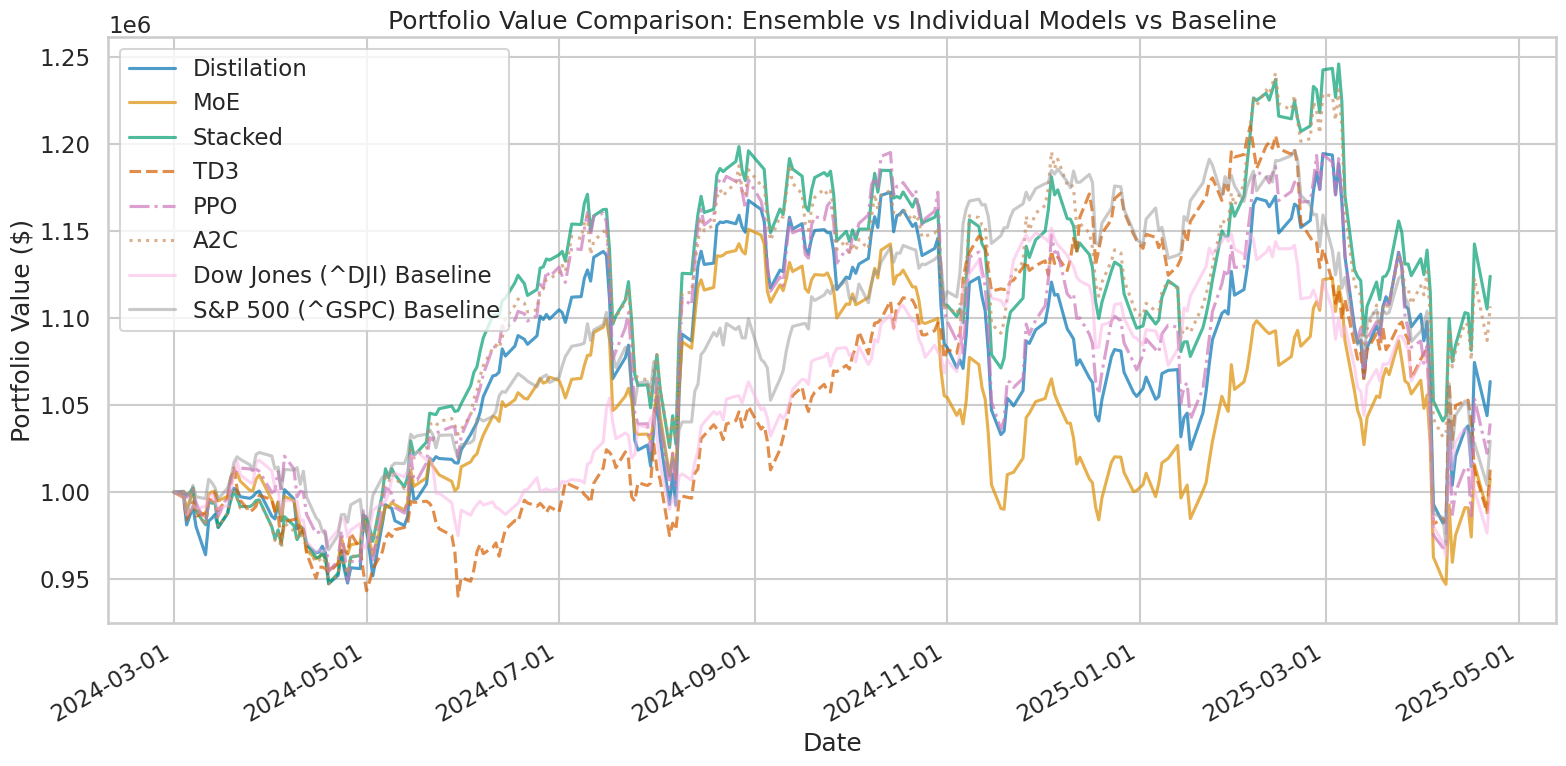

In [70]:
%matplotlib inline
sns.set_theme(style='whitegrid', context='talk')

# Optionally, define a Seaborn color palette
palette = sns.color_palette("colorblind", 8)

# Convert 'date' columns to datetime if they are not already
# ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
student_results['date'] = pd.to_datetime(student_results['date'])
moe_resuts['date'] = pd.to_datetime(moe_resuts['date'])
gating_results['date'] = pd.to_datetime(gating_results['date'])
td3_results['date'] = pd.to_datetime(td3_results['date'])
# ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
ppo_results['date'] = pd.to_datetime(ppo_results['date'])
a2c_results['date'] = pd.to_datetime(a2c_results['date'])
dji['date'] = pd.to_datetime(baseline_df['date'])
snp['date'] = pd.to_datetime(baseline_df_snp['date'])

# Create the figure
plt.figure(figsize=(16, 8))

# Plot each series using Seaborn's palette for consistency
plt.plot(student_results['date'], student_results['account_value'], 
        label='Distilation', linestyle='-', alpha=0.7, color=palette[0])

plt.plot(moe_resuts['date'], moe_resuts['account_value'],
        label='MoE', linestyle='-', alpha=0.7, color=palette[1])

plt.plot(gating_results['date'], gating_results['account_value'],
        label='Stacked', linestyle='-', alpha=0.7, color=palette[2])

plt.plot(td3_results['date'],td3_results['account_value'], 
        label='TD3', linestyle='--', alpha=0.7, color=palette[3])
plt.plot(ppo_results['date'], ppo_results['account_value'], 
        label='PPO', linestyle='-.', alpha=0.7, color=palette[4])
plt.plot(a2c_results['date'], a2c_results['account_value'], 
        label='A2C', linestyle=':', alpha=0.7, color=palette[5])
plt.plot(dji['date'], dji['close'], 
        label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[6])

plt.plot(snp['date'], snp['close'],
        label='S&P 500 (^GSPC) Baseline', linestyle='-', alpha=0.5, color=palette[7])


# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add titles and labels
plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the performance metrics for each strategy
data = {
    "S&P": {
        "Annual Return": 0.025800,
        "Sharpe Ratio": 0.229749,
        "Sortino Ratio": 0.326733,
    },
    "DJI": {
        "Annual Return": 0.002245,
        "Sharpe Ratio": 0.094902,
        "Sortino Ratio": 0.137024,
    },
    "Distillation": {
        "Annual Return": 0.088534,
        "Sharpe Ratio": 0.473458,
        "Sortino Ratio": 0.689922,
    },
    "MoE": {
        "Annual Return": 0.108448,
        "Sharpe Ratio": 0.582429,
        "Sortino Ratio": 0.841239,
    },
    "Stacked": {
        "Annual Return": 0.110635,
        "Sharpe Ratio": 0.598547,
        "Sortino Ratio": 0.860137,
    }
}

# Convert to DataFrame
df = pd.DataFrame(data).T

# Select metrics to plot
metrics_to_plot = ["Annual Return", "Sharpe Ratio", "Sortino Ratio"]

# Plot
df[metrics_to_plot].plot(kind="bar", figsize=(12, 6))
plt.title("Performance Comparison of Baselines and Ensemble Models (No Omega Ratio)")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title="Metrics")
plt.show()


/tmp/ipykernel_7119/2536862946.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


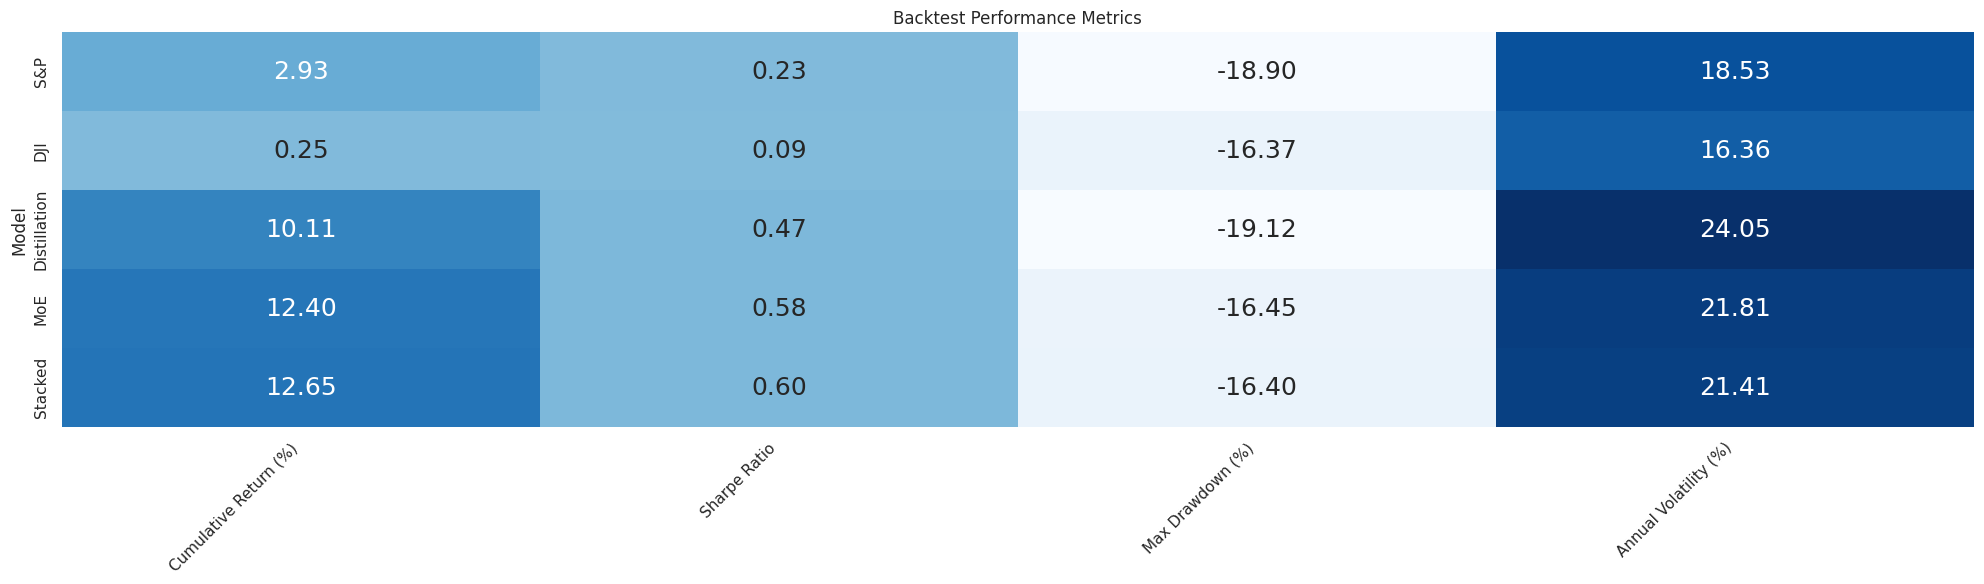

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame with selected metrics only
data = {
    "Model": ["S&P", "DJI", "Distillation", "MoE", "Stacked"],
    "Cumulative Return (%)": [i*100 for i in [0.029332, 0.002548, 0.101064, 0.123954, 0.126471]],
    "Sharpe Ratio": [0.23, 0.09, 0.47, 0.58, 0.60],
    "Max Drawdown (%)": [-18.90, -16.37, -19.12, -16.45, -16.40],
    "Annual Volatility (%)": [18.53, 16.36, 24.05, 21.81, 21.41],
    # "Sortino Ratio": [0.33, 0.14, 0.69, 0.84, 0.86],
}

df = pd.DataFrame(data)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6)) 

# Set index and plot
heatmap_data = df.set_index("Model")
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", cbar=False, annot_kws={"size": 18})

plt.title("Backtest Performance Metrics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


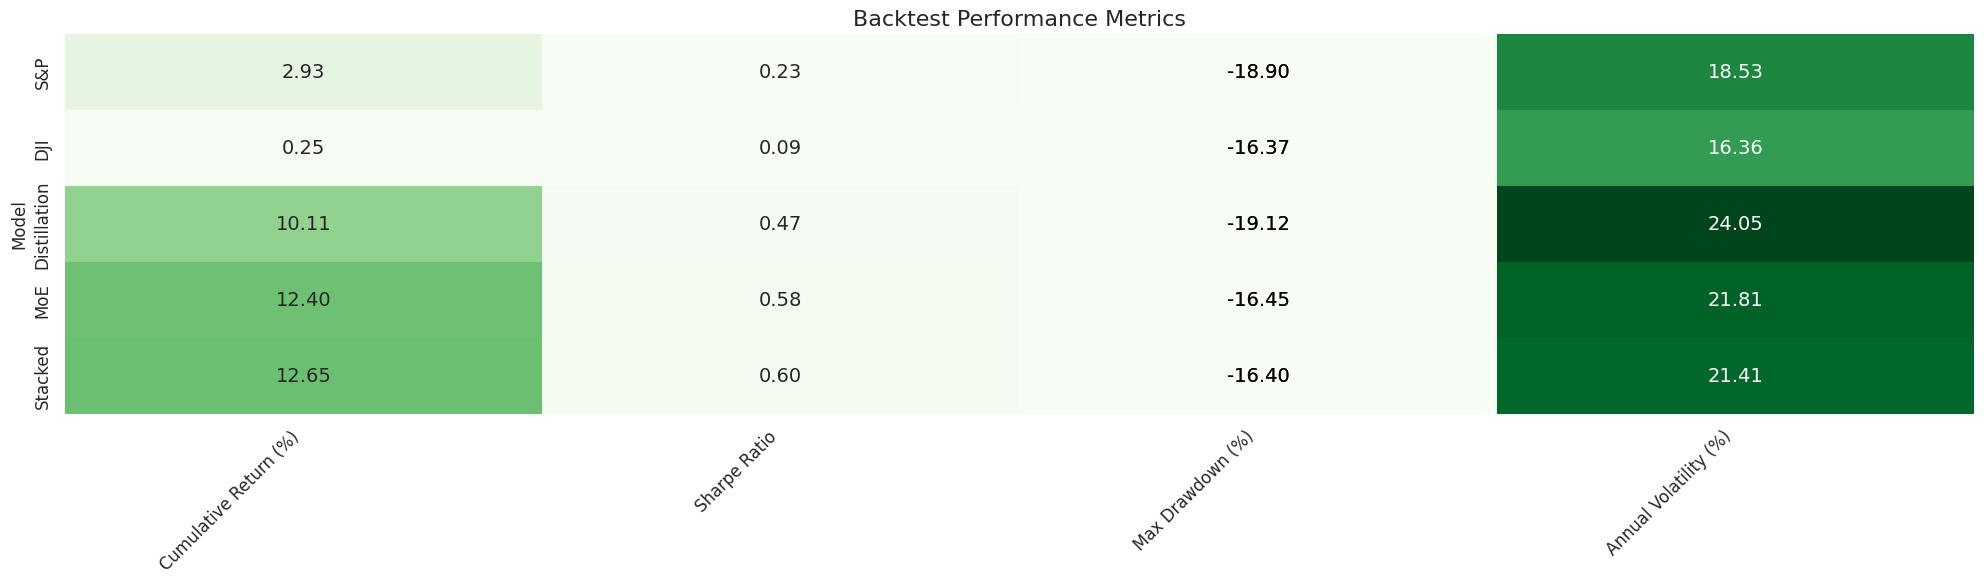

In [7]:
# Create a custom colormap mask for red drawdowns
colors = heatmap_data.copy()

# Normalize all values to [0,1] for proper coloring except drawdown
norm_data = heatmap_data.copy()
norm_data["Max Drawdown (%)"] = 0  # Temporarily zero out to prevent colormap conflict

# Plot everything normally
plt.figure(figsize=(20, 6))
sns.heatmap(norm_data, annot=heatmap_data, fmt=".2f", cmap="Greens", cbar=False, annot_kws={"size": 14})

# Overlay Max Drawdown column with red colormap
drawdown_col_idx = list(heatmap_data.columns).index("Max Drawdown (%)")
for i in range(len(heatmap_data)):
    val = heatmap_data.iloc[i, drawdown_col_idx]
    plt.gca().add_patch(plt.Rectangle((drawdown_col_idx, i), 1, 1, fill=True, color="salmon", zorder=0))
    plt.text(drawdown_col_idx + 0.5, i + 0.5, f"{val:.2f}", 
             ha='center', va='center', color='black', fontsize=14)

plt.title("Backtest Performance Metrics", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

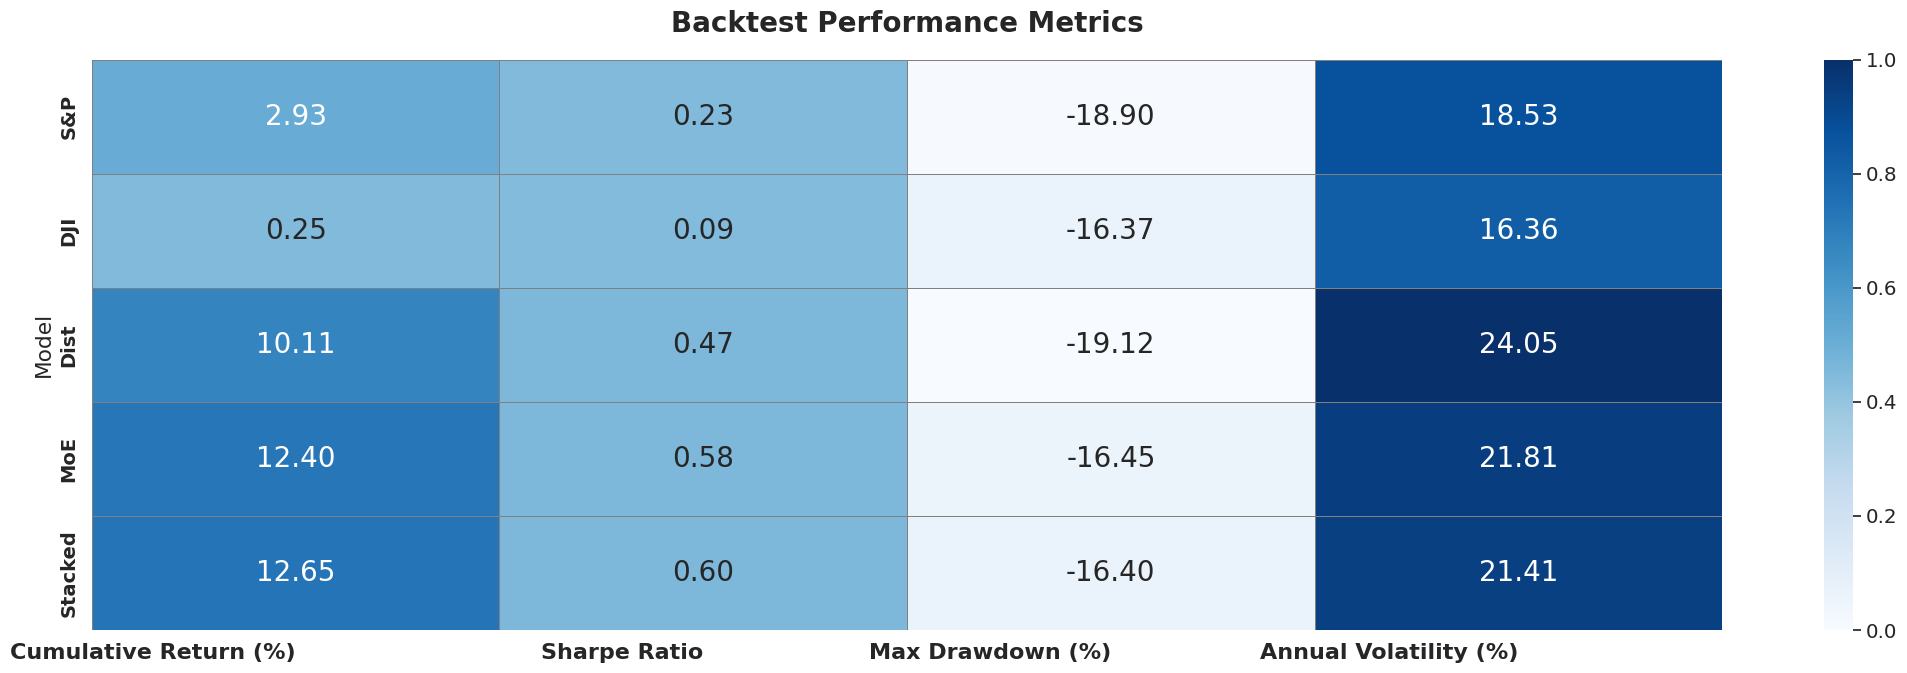

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame
data = {
    "Model": ["S&P", "DJI", "Dist", "MoE", "Stacked"],
    "Cumulative Return (%)": [i*100 for i in [0.029332, 0.002548, 0.101064, 0.123954, 0.126471]],
    "Sharpe Ratio": [0.23, 0.09, 0.47, 0.58, 0.60],
    "Max Drawdown (%)": [-18.90, -16.37, -19.12, -16.45, -16.40],
    "Annual Volatility (%)": [18.53, 16.36, 24.05, 21.81, 21.41],
}

df = pd.DataFrame(data)

# Plotting setup
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(22, 7))

# Set index
heatmap_data = df.set_index("Model")

# Normalize across all values for consistent coloring
norm_data = (heatmap_data - heatmap_data.min().min()) / (heatmap_data.max().max() - heatmap_data.min().min())

# Heatmap
ax = sns.heatmap(
    norm_data,
    annot=heatmap_data,
    fmt=".2f",
    cmap="Blues",
    cbar=True,
    annot_kws={"size": 20},
    linewidths=0.5,
    linecolor='gray'
)

# Titles and labels
plt.title("Backtest Performance Metrics", fontsize=20, fontweight='bold', pad=20)
plt.xticks(ha="right", fontsize=16, fontweight='bold')
 # shift by 0.1 units on x-axis
plt.yticks(fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
